In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
import scipy
from collections import namedtuple
import numpy as np
import cupy as cp
import math
import json

%run utils.ipynb


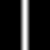
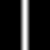
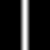
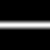
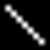
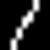
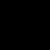

In [259]:
IMAGE_SIZE = 9
BAR_HALF_WIDTH = 0
vert_bar_image = Image.new('L', (IMAGE_SIZE, IMAGE_SIZE))

center_pt = IMAGE_SIZE // 2
coords = [
    (center_pt - BAR_HALF_WIDTH, 0),
    (center_pt + BAR_HALF_WIDTH, IMAGE_SIZE - 1)
]
ImageDraw.Draw(vert_bar_image).rectangle(coords, outline=255, fill=255)

vert_bar_image2 = Image.new('L', (IMAGE_SIZE, IMAGE_SIZE))
coords = [
    (center_pt - BAR_HALF_WIDTH + BAR_HALF_WIDTH, 0),
    (center_pt + BAR_HALF_WIDTH + BAR_HALF_WIDTH, IMAGE_SIZE - 1)
]
ImageDraw.Draw(vert_bar_image2).rectangle(coords, outline=255, fill=255)

vert_bar_image3 = Image.new('L', (IMAGE_SIZE, IMAGE_SIZE))
coords = [
    (center_pt - BAR_HALF_WIDTH - BAR_HALF_WIDTH, 0),
    (center_pt + BAR_HALF_WIDTH - BAR_HALF_WIDTH, IMAGE_SIZE - 1)
]
ImageDraw.Draw(vert_bar_image3).rectangle(coords, outline=255, fill=255)

horz_bar_image = vert_bar_image.rotate(90)
diag_bar_image = vert_bar_image.rotate(45)
diag_bar_image2 = vert_bar_image.rotate(-30)
empty_image = Image.new('L', (IMAGE_SIZE, IMAGE_SIZE))

all_images = [vert_bar_image, vert_bar_image2, vert_bar_image3, horz_bar_image, diag_bar_image, diag_bar_image2, empty_image]
display_images(list(map(lambda x: x.resize((50, 50)), all_images)))

In [3]:
def display_kernel_raw(kernel, precision=1):
    kernel = kernel.reshape(IMAGE_SIZE, IMAGE_SIZE)
    format_string = '{:4.' + str(precision) + 'f}'
    
    for r in kernel:
        s = ''
        for c in r:
            s += ' ' + format_string.format(c)

        print(s)   


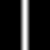
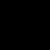

In [264]:
SAMPLES_COUNT = 300
# images_source = [vert_bar_image, vert_bar_image, horz_bar_image]
# images_source = [vert_bar_image, horz_bar_image, horz_bar_image, horz_bar_image, diag_bar_image]
images_source = [vert_bar_image, empty_image, empty_image, empty_image, empty_image]
images_source_set = dict()

for s in images_source:
    images_source_set[id(s)] = [s, 0]

images_asbytes = list(map(lambda x: np.array(x).ravel(), images_source))
random_indices = np.random.randint(len(images), size=SAMPLES_COUNT)
IMAGES = []

for i in random_indices:
    IMAGES.append(images_asbytes[i])
    images_source_set[id(images_source[i])][1] += 1
    
IMAGES = np.array(IMAGES)

images_to_display = []
images_source_caps = []

for image, counter in images_source_set.values():
    images_to_display.append(image)
    images_source_caps.append(f'{counter} ({counter/IMAGES.shape[0] * 100:.0f}%)')

display_images(list(map(lambda x: x.resize((50, 50)), images_to_display)), captions=images_source_caps)

In [282]:
mask1 = np.ones(IMAGE_SIZE * IMAGE_SIZE) # full cover
mask2 = np.zeros((IMAGE_SIZE, IMAGE_SIZE)) # horz bar 
mask2[3,:] = 1
mask2[4,:] = 1
mask2[5,:] = 1
mask3 = mask2.T
mask2 = mask2.reshape(-1)
mask3 = mask3.reshape(-1) # vert bar
CLUSTER_MASKS = np.array([mask1, mask2, mask3])

means = 1 / np.pow(CLUSTER_MASKS.sum(axis=1), 1)
sigmas = means / 3
CLUSTERS = np.random.normal(means, sigmas, size=(CLUSTER_MASKS.shape[1], CLUSTER_MASKS.shape[0])).T
# CLUSTERS = np.ones((IMAGE_SIZE * IMAGE_SIZE)).reshape(1, -1) # oja falls into inf/nan here

In [283]:
# mean = 1 / np.pow(IMAGE_SIZE * IMAGE_SIZE, 1)
# sigma = mean / 3
# CLUSTERS = np.random.normal(mean, sigma, size=(IMAGE_SIZE * IMAGE_SIZE))
# CLUSTER_MASKS = (CLUSTERS > 0)

In [284]:
nu = 0.05
batch_size = 300
epochs = 10
image_indices = np.arange(IMAGES.shape[0])
method = 'oja' # oja, classic, rdzb

for batches in tqdm(range(epochs)):
    np.random.shuffle(image_indices)
    
    for ii in image_indices[:batch_size]:
        image = IMAGES[ii] / 255
        xes = image * CLUSTER_MASKS
        yeks = image @ CLUSTERS.T

        if method == 'oja':
            grow = (nu * yeks).reshape(1, -1).T
            grow = xes * grow 
            assert np.array_equal(xes[0] * (nu * yeks[0]), grow[0])
            stabil = (nu * np.pow(yeks, 2)).reshape(1, -1).T
            stabil = CLUSTERS * stabil 
            CLUSTERS = CLUSTERS + grow - stabil
        elif method == 'classic':
            denom = np.pow(CLUSTERS + xes * (nu * yeks).reshape(1, -1).T, 2)
            denom = np.sqrt(np.sum(denom, axis=1).reshape(1, -1).T)
            assert np.array_equal(denom[0], [np.sqrt(np.pow(CLUSTERS[0] + (nu * yeks[0] * xes[0]), 2).sum())])
            nomin = CLUSTERS + xes * (nu * yeks).reshape(1, -1).T
            CLUSTERS = nomin / denom
        elif method == 'rdzb':
            nomin = CLUSTERS + xes * (nu * yeks).reshape(1, -1).T
            denom = nomin.max(axis=1)
            assert np.array_equal(denom[0], nomin[0].max())
            CLUSTERS = (nomin.T / denom).T
        else:
            assert False, method

    # Pruning
    CLUSTER_MASKS = (CLUSTERS.T >= np.max(CLUSTERS, axis=1) * 0.75).T
    CLUSTERS = CLUSTERS * CLUSTER_MASKS
    
    nu *= 0.9

for i, c in enumerate(CLUSTER_MASKS):
    print(f'Cluster #{i}')
    display_kernel_raw(c.astype(np.uint8), precision=0)
    print('\n')

  0%|          | 0/10 [00:00<?, ?it/s]

Cluster #0
    0    0    0    0    1    0    0    0    0
    0    0    0    0    1    0    0    0    0
    0    0    0    0    1    0    0    0    0
    0    0    0    0    1    0    0    0    0
    0    0    0    0    1    0    0    0    0
    0    0    0    0    1    0    0    0    0
    0    0    0    0    1    0    0    0    0
    0    0    0    0    1    0    0    0    0
    0    0    0    0    1    0    0    0    0


Cluster #1
    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0
    0    0    0    0    1    0    0    0    0
    0    0    0    0    1    0    0    0    0
    0    0    0    0    1    0    0    0    0
    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0


Cluster #2
    0    0    0    0    1    0    0    0    0
    0    0    0    0    1    0    0    0    0
    0    0    0    0    1    0    0    0   

In [274]:
[np.sqrt(np.pow(CLUSTERS[0] + (nu * yeks[0] * xes[0]), 2).sum())]

[np.float64(0.11979017906172475)]